# Deep Learning for Text and Sequences

## Sentiment Analysis

Sentiment analysis is the task of determinining whether a text (such as a movie review or restaurant review) is positive or negative. For example, let's consider the reviews posted at IMDB.

![imdb.png](imdb.png)

Here is one review from that website:

In [77]:
texts[23525]

'Tis is a farly typical Tom and Jerry short-a situation is designed, conflict arises and mayhem ensues. The characters behave in appropriate ways, the natural tensions between various characters leads to general chaos. The best (and funniest) part is when the peace treaty is in force and respected-all sorts of strange wonders appear before your eyes. A word of warning-it is most unwise to allow Tom to help you perform your morning cleansing routine! Highly recommended.'

In [78]:
labels[23525] #0=negative, 1=positive

1

## We want to train a network so as to predict whether it is positive or negative. 

### Training an Embedding from Scratch on IMDB

In [6]:
from keras.layers import Embedding

from keras.datasets import imdb
from keras import preprocessing
max_features = 10000 #just consider the top 10000 most common words
maxlen = 100 #cut off the reviews to the first maxlen words. Increasing to 1000 you get validation accuracy of ~90%

(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=max_features)
#add zeros or cut reviews so that they have the same size
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) 
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)



In [7]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(10000, 100, input_length=maxlen)) #learn an 8-dimensional embedding
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10001     
Total params: 1,010,001
Trainable params: 1,010,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=10,
batch_size=32, validation_split=0.2)

Validation Accuracy > 83%, with the first 100 words. Not bad.

### Using a pretrained Embedding

There are several embeddings we could use... Download the raw IMDB data from http://mng.bz/0tIo. 

In [91]:
#some preprocessing of the data

import os
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 
training_samples = 20000 
validation_samples = 5000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [92]:
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [93]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [94]:
#put the embedding in the architecture

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [95]:
#load the pretrained embedding in the embedding layer and freeze the parameters
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [96]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 20000 samples, validate on 4000 samples
Epoch 1/10
20000/20000 [==============================] - 8s 390us/step - loss: 0.6862 - acc: 0.5460 - val_loss: 0.5991 - val_acc: 0.6793
Epoch 2/10
20000/20000 [==============================] - 7s 366us/step - loss: 0.5673 - acc: 0.7063 - val_loss: 0.5577 - val_acc: 0.7192
Epoch 3/10
20000/20000 [==============================] - 7s 354us/step - loss: 0.4907 - acc: 0.7650 - val_loss: 0.6030 - val_acc: 0.6990
Epoch 4/10
20000/20000 [==============================] - 7s 362us/step - loss: 0.4417 - acc: 0.7926 - val_loss: 0.5734 - val_acc: 0.7190
Epoch 5/10
20000/20000 [==============================] - 7s 367us/step - loss: 0.4093 - acc: 0.8138 - val_loss: 0.7038 - val_acc: 0.6933
Epoch 6/10
20000/20000 [==============================] - 8s 377us/step - loss: 0.3754 - acc: 0.8273 - val_loss: 0.5994 - val_acc: 0.7160
Epoch 7/10
20000/20000 [==============================] - 8s 379us/step - loss: 0.3321 - acc: 0.8514 - val_loss: 0.7523 - v

Validation Accuracy: 72%. Somehow it performs worse than when trainning our model from scratch. Possible reason: the  embedding has been trained for general purpose tasks.

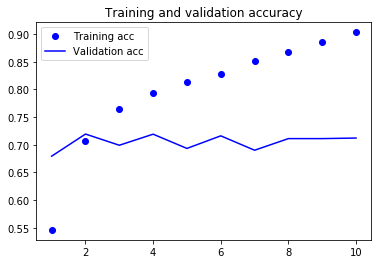

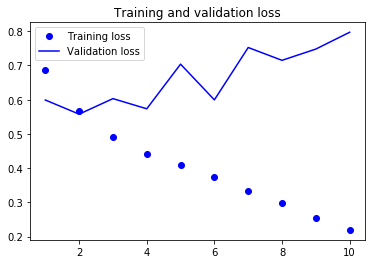

In [97]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Recurrent Neural Networks for Sentiment Analysis

### SImple RNN


In [108]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 100
batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
     num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 100)
input_test shape: (25000, 100)


In [109]:
from keras.layers import SimpleRNN
from keras.layers import Dense
model = Sequential() 
model.add(Embedding(max_features, 32)) 
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc']) 
history = model.fit(input_train, y_train,
    epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.6415 - acc: 0.6119 - val_loss: 0.4914 - val_acc: 0.7830
Epoch 2/10
20000/20000 [==============================] - 20s 986us/step - loss: 0.3958 - acc: 0.8318 - val_loss: 0.5077 - val_acc: 0.7880
Epoch 3/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.2734 - acc: 0.8931 - val_loss: 0.4007 - val_acc: 0.8242
Epoch 4/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.1822 - acc: 0.9334 - val_loss: 0.4718 - val_acc: 0.8030
Epoch 5/10
20000/20000 [==============================] - 20s 985us/step - loss: 0.1133 - acc: 0.9621 - val_loss: 0.4653 - val_acc: 0.8244
Epoch 6/10
20000/20000 [==============================] - 19s 971us/step - loss: 0.0637 - acc: 0.9806 - val_loss: 0.5391 - val_acc: 0.8124
Epoch 7/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.0339 - acc: 0.9907 - val_loss: 0.6533 - va

Accuracy of 82.5%, worse than the first simple approach we tried. 

### Long Short-Term Memory (LSTM)

In [110]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32)) #32D embedding
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 72s 4ms/step - loss: 0.5005 - acc: 0.7563 - val_loss: 0.3815 - val_acc: 0.8464
Epoch 2/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.3084 - acc: 0.8751 - val_loss: 0.3809 - val_acc: 0.8314
Epoch 3/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.2529 - acc: 0.8979 - val_loss: 0.3386 - val_acc: 0.8500
Epoch 4/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2189 - acc: 0.9155 - val_loss: 0.3544 - val_acc: 0.8442
Epoch 5/10
20000/20000 [==============================] - 64s 3ms/step - loss: 0.1984 - acc: 0.9252 - val_loss: 0.3606 - val_acc: 0.8484
Epoch 6/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.1778 - acc: 0.9313 - val_loss: 0.3966 - val_acc: 0.8410
Epoch 7/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.1650 - acc: 0.9394 - val_loss: 0.3951 - val_acc:

Accuracy of 84-85%. Better than simple RNN, but only slightly better than the first approach.